In [81]:
import sys
import optparse
import time
import sys
#from transformers import BertForSequenceClassification, BertTokenizer
#import nltk
import os
import requests
import tensorflow as tf
import random

# Add this at the beginning of your script
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [35]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
csv_file = "./sentences_sentiment1.csv"

df = pd.read_csv(csv_file)

len(df)

50918

In [36]:
df["date"] = pd.to_datetime(df["date"], errors='coerce')  # Convert to datetime, ignore errors

print("Earliest date:", df["date"].min())
print("Latest date:", df["date"].max())

Earliest date: 2023-07-12 10:27:37+00:00
Latest date: 2025-04-11 10:41:54+00:00


remove timestamps

In [37]:
import re

def remove_all_timestamps(text):
    return re.sub(r"\[[^\]]*\]", "", text).strip()


df["sentence"] = df["sentence"].apply(remove_all_timestamps)

Extract date in eastern time

In [38]:
# Convert to datetime and localize
df["datetime"] = pd.to_datetime(df["date"], utc=True)
df["datetime_et"] = df["datetime"].dt.tz_convert("America/New_York")
# Extract date part only (in Eastern Time)
df["market_day"] = df["datetime_et"].dt.date


logit into proper list

In [39]:
import re
import ast

def fix_and_parse_logit(logit_str):
    if isinstance(logit_str, str):
        # Insert commas between numbers using regex
        logit_str = re.sub(r'(?<=\d) (?=\d)', ',', logit_str.strip())
        try:
            return ast.literal_eval(logit_str)
        except:
            return [0.0, 0.0, 0.0]  # fallback if still broken
    return logit_str  # already a list

df["logit"] = df["logit"].apply(fix_and_parse_logit)


prediction
neutral     28767
negative    11919
positive    10232
Name: count, dtype: int64


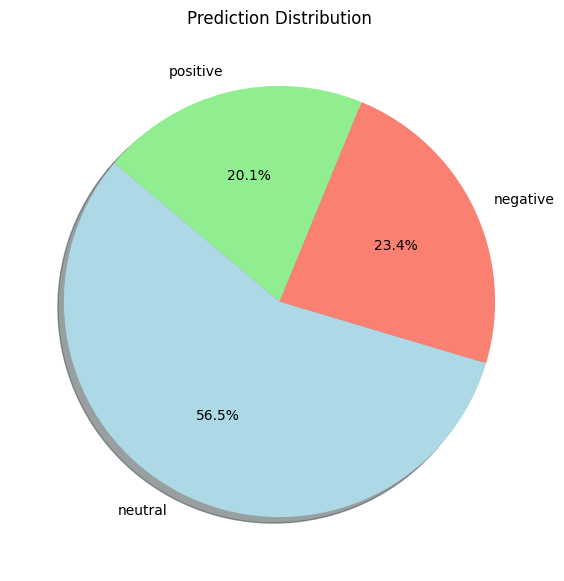

In [40]:
print(df["prediction"].value_counts())
counts = df["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()

In [41]:
import re

# 1. Expanded keyword lists with more granular categorization
# Direct NVIDIA references
nvidia_direct_keywords = [
    "nvidia", "nvda", "jensen huang", "jensen wang", "blackwell", "hopper", "ampere", "ada lovelace",
    "cuda", "tensor cores", "cuda cores", "nvlink", "mellanox", "geforce", "rtx", "gtx",
    "dgx", "drive", "jetson", "turing", "shield", "omniverse"
]

# Related technology terms
tech_keywords = [
    "gpu", "accelerator", "chip", "semiconductor", "semiconductors", "chipset",
    "graphics card", "data center", "datacenter", "high performance computing", "hpc",
    "parallel computing", "inference", "training", "ray tracing", "dlss"
]

# AI and computing ecosystem
ai_ecosystem_keywords = [
    "ai", "artificial intelligence", "machine learning", "deep learning", "neural network",
    "generative ai", "llm", "large language model", "transformer", "diffusion model",
    "computer vision", "accelerated computing", "supercomputing", "ai inference"
]

# Key partners and competitors
partners_competitors_keywords = [
    "tsmc", "intel", "amd", "arm", "google", "microsoft", "amazon", "aws", "azure",
    "meta", "openai", "oracle", "ibm", "dell", "hp", "supermicro", "qualcomm", "broadcom",
    "apple", "samsung", "hyperscaler"
]

# Market conditions and macroeconomic factors
market_keywords = [
    "nasdaq", "semiconductor index", "philadelphia semiconductor", "sox", "chip stocks",
    "tech stocks", "fed", "fomc", "interest rate", "inflation", "gdp", "recession",
    "market selloff", "rally", "bear market", "bull market", "market crash"
]

# Geopolitical and supply chain risks
risk_keywords = [
    "china", "taiwan", "export control", "sanctions", "tariff", "trade war", "chip act",
    "regulation", "antitrust", "supply chain", "chip shortage", "inventory", "allocation",
    "wafer", "foundry", "fab", "downturn", "headwind", "competitive pressure"
]

# Sentiment and analyst terms
sentiment_keywords = [
    "upgrade", "downgrade", "price target", "buy rating", "sell rating", "outperform",
    "underperform", "overweight", "underweight", "bullish", "bearish", "guidance",
    "forecast", "outlook", "revenue growth", "margin", "valuation", "multiple"
]

# 2. Combine all keywords into master lists but maintain separate categories for analysis
all_nvidia_keywords = nvidia_direct_keywords + tech_keywords + ai_ecosystem_keywords + partners_competitors_keywords
all_macro_keywords = market_keywords + risk_keywords + sentiment_keywords

# 3. Create pattern for regex matching with word boundaries
nvidia_pattern = r"\b(" + "|".join(re.escape(k) for k in all_nvidia_keywords) + r")\b"
macro_pattern = r"\b(" + "|".join(re.escape(k) for k in all_macro_keywords) + r")\b"

# 4. Create more granular flags for better filtering and analysis
def categorize_sentence(row):
    sentence = row["sentence"].lower()

    # Create flags for each category
    has_direct_nvidia = any(term in sentence for term in nvidia_direct_keywords)
    has_tech = any(term in sentence for term in tech_keywords)
    has_ai = any(term in sentence for term in ai_ecosystem_keywords)
    has_partner_competitor = any(term in sentence for term in partners_competitors_keywords)
    has_market = any(term in sentence for term in market_keywords)
    has_risk = any(term in sentence for term in risk_keywords)
    has_sentiment = any(term in sentence for term in sentiment_keywords)

    # Combined flags
    has_any_nvidia = has_direct_nvidia or has_tech or has_ai or has_partner_competitor
    has_any_macro = has_market or has_risk or has_sentiment

    # Relevance score (higher = more relevant to NVIDIA)
    relevance_score = (has_direct_nvidia * 3) + (has_tech * 2) + (has_ai * 2) + \
                      (has_partner_competitor * 1) + (has_market * 0.5) + \
                      (has_risk * 1) + (has_sentiment * 0.5)

    return {
        "has_direct_nvidia": has_direct_nvidia,
        "has_tech": has_tech,
        "has_ai": has_ai,
        "has_partner_competitor": has_partner_competitor,
        "has_market": has_market,
        "has_risk": has_risk,
        "has_sentiment": has_sentiment,
        "has_any_nvidia": has_any_nvidia,
        "has_any_macro": has_any_macro,
        "relevance_score": relevance_score
    }

# 5. Apply the categorization function
categorized = df.apply(categorize_sentence, axis=1)

# 6. Add new columns to dataframe
for key in categorized.iloc[0].keys():
    df[key] = categorized.apply(lambda x: x[key])

# 7. Create filtered dataframes with different relevance thresholds
# Primary NVIDIA relevant dataframe (includes direct mentions and strong indirect relevance)
df_nvda_relevant = df[(df["has_direct_nvidia"]) |
                      (df["has_tech"] & df["has_ai"]) |
                      ((df["has_partner_competitor"] | df["has_risk"]) & df["relevance_score"] >= 2)].copy()

# Secondary macro risk dataframe (more general market conditions that might affect NVIDIA)
df_macro_risk = df[(df["has_any_macro"]) & (df["relevance_score"] < 2)].copy()

# Highly relevant NVIDIA dataframe (most focused)
df_nvda_core = df[df["relevance_score"] >= 3].copy()

print(f"Total rows: {len(df)}")
print(f"NVIDIA relevant rows: {len(df_nvda_relevant)} ({len(df_nvda_relevant)/len(df):.1%})")
print(f"Macro risk rows: {len(df_macro_risk)} ({len(df_macro_risk)/len(df):.1%})")
print(f"NVIDIA core rows: {len(df_nvda_core)} ({len(df_nvda_core)/len(df):.1%})")

Total rows: 50918
NVIDIA relevant rows: 1865 (3.7%)
Macro risk rows: 5952 (11.7%)
NVIDIA core rows: 3773 (7.4%)


prediction
neutral     4769
negative    3608
positive    3213
Name: count, dtype: int64


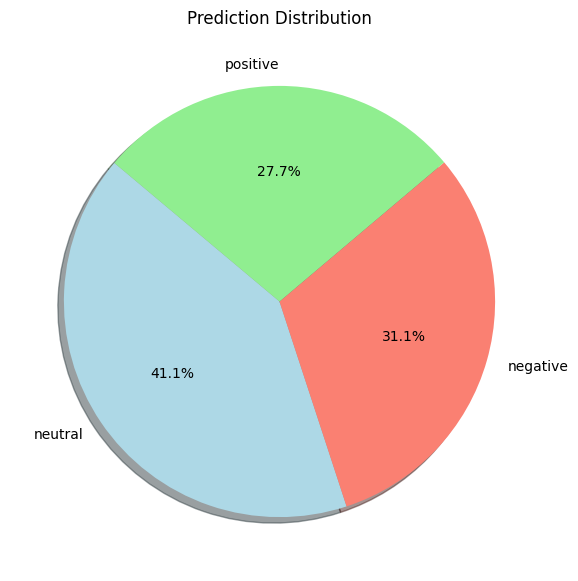

In [42]:

# Combine all datasets
# Note: Be careful of duplicates since df_nvda_core likely overlaps with df_nvda_relevant
# First, get unique IDs from each dataset to avoid duplicates
relevant_ids = set(df_nvda_relevant.index)
core_ids = set(df_nvda_core.index)
macro_ids = set(df_macro_risk.index)

# Filter out duplicates from core dataset that are already in relevant dataset
unique_core_ids = core_ids - relevant_ids
df_nvda_core_unique = df_nvda_core.loc[list(unique_core_ids)]

# Filter out duplicates from macro dataset that are in either relevant or core
unique_macro_ids = macro_ids - relevant_ids - core_ids
df_macro_risk_unique = df_macro_risk.loc[list(unique_macro_ids)]

# Combine the filtered datasets
df_combined = pd.concat([df_nvda_relevant, df_nvda_core_unique, df_macro_risk_unique])
df_combined_intermediate = pd.concat([df_nvda_relevant, df_macro_risk, df_nvda_core])
print(df_combined_intermediate["prediction"].value_counts())
counts = df_combined_intermediate["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()

In [43]:
def enhance_nvidia_sentiment(row):
    """
    Enhance sentiment analysis specifically for NVIDIA using category-aware rules
    """
    # Get original sentiment values
    orig_logit = row['logit'] if isinstance(row['logit'], list) else [0.33, 0.33, 0.34]
    orig_sentiment_score = row['sentiment_score']
    orig_prediction = row['prediction']

    # Initialize enhanced values
    enhanced_logit = orig_logit.copy()
    enhanced_score = orig_sentiment_score
    enhanced_prediction = orig_prediction

    # Extract text and lowercase for analysis
    sentence = row['sentence'].lower()

    # Factor weights (adjust these based on performance)
    direct_nvidia_weight = 1.0
    competitor_weight = 0.8
    china_weight = 0.7
    tech_weight = 0.6
    market_weight = 0.5

    # Track applied rules for explanation
    applied_rules = []

    # ------------------------
    # Rule 1: Direct NVIDIA mentions (strongest factor)
    # ------------------------
    if row["has_direct_nvidia"]:
        # Direct mentions - enhance existing sentiment direction
        if orig_prediction == 'positive' or orig_sentiment_score > 0.2:
            enhanced_logit[0] = min(1.0, enhanced_logit[0] * (1 + 0.3 * direct_nvidia_weight))
            enhanced_logit[1] = max(0.0, enhanced_logit[1] * (1 - 0.3 * direct_nvidia_weight))
            enhanced_score = min(1.0, enhanced_score + 0.2 * direct_nvidia_weight)
            applied_rules.append("Direct NVIDIA positive enhancement")

        elif orig_prediction == 'negative' or orig_sentiment_score < -0.2:
            enhanced_logit[1] = min(1.0, enhanced_logit[1] * (1 + 0.3 * direct_nvidia_weight))
            enhanced_logit[0] = max(0.0, enhanced_logit[0] * (1 - 0.3 * direct_nvidia_weight))
            enhanced_score = max(-1.0, enhanced_score - 0.2 * direct_nvidia_weight)
            applied_rules.append("Direct NVIDIA negative enhancement")

    # ------------------------
    # Rule 2: Competitor analysis (important factor)
    # ------------------------
    if row["has_partner_competitor"]:
        # Check for competitors with contextual sentiment
        competitors = ["intel", "amd", "qualcomm"]
        if any(comp in sentence for comp in competitors):
            # Competitor sentiment inversion (their bad news is good for NVIDIA)
            if any(neg_term in sentence for neg_term in ["struggle", "decline", "missed", "layoff", "delay",
                                                        "down", "fall", "weak", "problem", "issue", "challenge",
                                                        "bad news", "setback", "behind", "lost"]):
                enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3 * competitor_weight)
                enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.3 * competitor_weight)
                enhanced_score = min(1.0, abs(orig_sentiment_score) * 0.7 + 0.3)  # Invert and boost
                enhanced_prediction = 'positive'
                applied_rules.append("Competitor negative → NVIDIA positive")

            elif any(pos_term in sentence for pos_term in ["gain", "advance", "beat", "success", "lead",
                                                          "positive", "growth", "strong", "ahead", "win"]):
                enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3 * competitor_weight)
                enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * competitor_weight)
                enhanced_score = max(-1.0, -abs(orig_sentiment_score) * 0.7 - 0.3)  # Invert and make negative
                enhanced_prediction = 'negative'
                applied_rules.append("Competitor positive → NVIDIA negative")

        # Check for partners with contextual sentiment
        partners = ["tsmc", "microsoft", "amazon", "google", "openai", "meta"]
        if any(partner in sentence for partner in partners):
            # Partner sentiment alignment (their good news is good for NVIDIA)
            if orig_prediction == 'positive' or orig_sentiment_score > 0.1:
                enhanced_logit[0] = min(1.0, enhanced_logit[0] * (1 + 0.2 * competitor_weight))
                enhanced_score = min(1.0, enhanced_score + 0.15 * competitor_weight)
                applied_rules.append("Partner positive → NVIDIA positive")

            elif orig_prediction == 'negative' or orig_sentiment_score < -0.1:
                enhanced_logit[1] = min(1.0, enhanced_logit[1] * (1 + 0.2 * competitor_weight))
                enhanced_score = max(-1.0, enhanced_score - 0.15 * competitor_weight)
                applied_rules.append("Partner negative → NVIDIA negative")

    # ------------------------
    # Rule 3: China & geopolitical risk
    # ------------------------
    if "china" in sentence or "taiwan" in sentence or "export control" in sentence:
        # China restrictions or export controls are negative for NVIDIA
        if any(restriction in sentence for restriction in ["restriction", "ban", "control", "limit",
                                                         "regulation", "tariff", "sanction"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4 * china_weight)
            enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * china_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.35 * china_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("China restrictions → NVIDIA negative")

        # China market growth is positive
        elif any(growth in sentence for growth in ["growth", "expand", "invest", "surge", "soar", "demand"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.35 * china_weight)
            enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.25 * china_weight)
            enhanced_score = min(1.0, enhanced_score + 0.3 * china_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("China growth → NVIDIA positive")

    # ------------------------
    # Rule 4: AI and tech market conditions
    # ------------------------
    if row["has_ai"] and row["has_tech"]:
        # AI + Tech co-occurrence is especially relevant to NVIDIA
        if orig_prediction == 'positive' or orig_sentiment_score > 0:
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.4 * tech_weight)
            enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.3 * tech_weight)
            enhanced_score = min(1.0, enhanced_score + 0.3 * tech_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("AI+Tech positive → NVIDIA strongly positive")

        elif orig_prediction == 'negative' or orig_sentiment_score < 0:
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4 * tech_weight)
            enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * tech_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.3 * tech_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("AI+Tech negative → NVIDIA strongly negative")

    # ------------------------
    # Rule 5: General market conditions
    # ------------------------
    if row["has_market"]:
        # Interest rates, Fed decisions impact high-growth tech like NVIDIA
        if any(term in sentence for term in ["interest rate", "fed", "inflation", "fomc"]):
            if any(neg in sentence for neg in ["hike", "raise", "higher", "increase", "hawkish"]):
                enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.25 * market_weight)
                enhanced_score = max(-1.0, enhanced_score - 0.2 * market_weight)
                if enhanced_score < -0.3:  # Only change prediction if strongly negative
                    enhanced_prediction = 'negative'
                applied_rules.append("Rate hikes → NVIDIA negative")

            elif any(pos in sentence for pos in ["cut", "lower", "decrease", "dovish", "pause"]):
                enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.25 * market_weight)
                enhanced_score = min(1.0, enhanced_score + 0.2 * market_weight)
                if enhanced_score > 0.3:  # Only change prediction if strongly positive
                    enhanced_prediction = 'positive'
                applied_rules.append("Rate cuts → NVIDIA positive")

        # Market sentiment impacts high-beta stocks like NVIDIA more
        if any(crash in sentence for crash in ["crash", "tumbl", "plummet", "bear market", "sell-off"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3 * market_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.25 * market_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("Market crash → NVIDIA strongly negative")

        elif any(rally in sentence for rally in ["rally", "bull market", "surge", "soar"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3 * market_weight)
            enhanced_score = min(1.0, enhanced_score + 0.25 * market_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("Market rally → NVIDIA strongly positive")

    # ------------------------
    # Rule 6: Supply chain and manufacturing
    # ------------------------
    if any(supply in sentence for supply in ["shortage", "supply chain", "inventory", "wafer", "foundry"]):
        if any(neg in sentence for neg in ["constraint", "issue", "problem", "challenge", "delay"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3)
            enhanced_score = max(-1.0, enhanced_score - 0.25)
            enhanced_prediction = 'negative'
            applied_rules.append("Supply chain issues → NVIDIA negative")

        elif any(pos in sentence for pos in ["improv", "resolv", "better", "easing"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3)
            enhanced_score = min(1.0, enhanced_score + 0.25)
            enhanced_prediction = 'positive'
            applied_rules.append("Supply chain improvement → NVIDIA positive")

    # ------------------------
    # Rule 7: Tariffs are particularly negative for semiconductor companies
    # ------------------------
    if "tariff" in sentence or "trade war" in sentence:
        enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4)
        enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3)
        enhanced_score = max(-1.0, enhanced_score - 0.35)
        enhanced_prediction = 'negative'
        applied_rules.append("Tariffs → NVIDIA strongly negative")

    # Normalize logits to sum to 1
    # --- Normalize logits safely ---
    logit_sum = sum(enhanced_logit)
    if logit_sum > 0:
        enhanced_logit = [x / logit_sum for x in enhanced_logit]
    else:
        enhanced_logit = [1/3, 1/3, 1/3]
        applied_rules.append("Logit normalization fallback to neutral")


    # Return enhanced values and explanation
    return {
        'nvda_enhanced_logit': enhanced_logit,
        'nvda_enhanced_score': enhanced_score,
        'nvda_enhanced_prediction': enhanced_prediction,
        'applied_rules': "; ".join(applied_rules) if applied_rules else "No specific rules applied"
    }

In [44]:
# Apply the enhancement function to your filtered dataframe
enhancements = df_nvda_relevant.apply(enhance_nvidia_sentiment, axis=1)

# Add the enhanced columns to your dataframe
df_nvda_relevant['nvda_enhanced_logit'] = enhancements.apply(lambda x: x['nvda_enhanced_logit'])
df_nvda_relevant['nvda_enhanced_score'] = enhancements.apply(lambda x: x['nvda_enhanced_score'])
df_nvda_relevant['nvda_enhanced_prediction'] = enhancements.apply(lambda x: x['nvda_enhanced_prediction'])
df_nvda_relevant['enhancement_explanation'] = enhancements.apply(lambda x: x['applied_rules'])


# Apply enhancements to the other filtered datasets
df_nvda_core_enhanced = df_nvda_core.copy()
df_macro_risk_enhanced = df_macro_risk.copy()

# Apply enhancement to NVIDIA core dataset
core_enhancements = df_nvda_core.apply(enhance_nvidia_sentiment, axis=1)
for key in ['nvda_enhanced_logit', 'nvda_enhanced_score', 'nvda_enhanced_prediction', 'applied_rules']:
    df_nvda_core_enhanced[key if key != 'applied_rules' else 'enhancement_explanation'] = core_enhancements.apply(lambda x: x[key])

# Apply enhancement to macro risk dataset - you might want to adjust weights in the function
macro_enhancements = df_macro_risk.apply(enhance_nvidia_sentiment, axis=1)
for key in ['nvda_enhanced_logit', 'nvda_enhanced_score', 'nvda_enhanced_prediction', 'applied_rules']:
    df_macro_risk_enhanced[key if key != 'applied_rules' else 'enhancement_explanation'] = macro_enhancements.apply(lambda x: x[key])

# Add a source column to track which dataset each row came from
df_nvda_relevant['source'] = 'nvidia_relevant'
df_nvda_core_enhanced['source'] = 'nvidia_core'
df_macro_risk_enhanced['source'] = 'macro_risk'

# Combine all datasets
# Note: Be careful of duplicates since df_nvda_core likely overlaps with df_nvda_relevant
# First, get unique IDs from each dataset to avoid duplicates
relevant_ids = set(df_nvda_relevant.index)
core_ids = set(df_nvda_core_enhanced.index)
macro_ids = set(df_macro_risk_enhanced.index)

# Filter out duplicates from core dataset that are already in relevant dataset
unique_core_ids = core_ids - relevant_ids
df_nvda_core_unique = df_nvda_core_enhanced.loc[list(unique_core_ids)]

# Filter out duplicates from macro dataset that are in either relevant or core
unique_macro_ids = macro_ids - relevant_ids - core_ids
df_macro_risk_unique = df_macro_risk_enhanced.loc[list(unique_macro_ids)]

# Combine the filtered datasets
df_combined = pd.concat([df_nvda_relevant, df_nvda_core_unique, df_macro_risk_unique])

print(f"Combined dataset size: {len(df_combined)} rows")

Combined dataset size: 9725 rows


prediction
neutral     28767
negative    11919
positive    10232
Name: count, dtype: int64


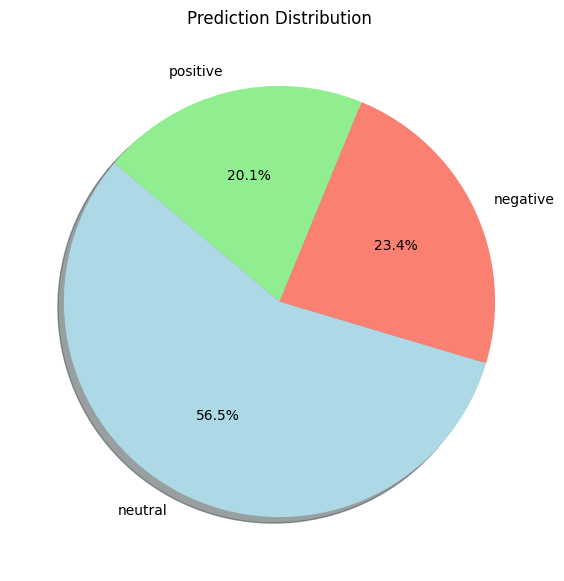

In [45]:
print(df["prediction"].value_counts())
counts = df["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()

In [46]:
# Calculate changes in sentiment prediction for the combined dataset
combined_sentiment_shift = (df_combined['prediction'] != df_combined['nvda_enhanced_prediction']).mean()
combined_positive_shift = ((df_combined['prediction'] != 'positive') &
                          (df_combined['nvda_enhanced_prediction'] == 'positive')).sum()
combined_negative_shift = ((df_combined['prediction'] != 'negative') &
                          (df_combined['nvda_enhanced_prediction'] == 'negative')).sum()

print(f"COMBINED DATASET ANALYSIS:")
print(f"Sentiment prediction changed in {combined_sentiment_shift:.2%} of rows")
print(f"Sentences shifted to positive: {combined_positive_shift}")
print(f"Sentences shifted to negative: {combined_negative_shift}")

# Analyze which rules were most frequently applied across the combined dataset
combined_rule_analysis = df_combined['enhancement_explanation'].str.split(';').explode().str.strip()
combined_top_rules = combined_rule_analysis.value_counts().head(10)
print("\nTop 10 applied rules in combined dataset:")
print(combined_top_rules)

# Additionally, analyze rule application by source dataset
print("\nRule application breakdown by dataset source:")
for source in df_combined['source'].unique():
    source_data = df_combined[df_combined['source'] == source]
    source_rules = source_data['enhancement_explanation'].str.split(';').explode().str.strip()
    source_top_rules = source_rules.value_counts().head(5)

    source_sentiment_shift = (source_data['prediction'] != source_data['nvda_enhanced_prediction']).mean()
    source_positive_shift = ((source_data['prediction'] != 'positive') &
                            (source_data['nvda_enhanced_prediction'] == 'positive')).sum()
    source_negative_shift = ((source_data['prediction'] != 'negative') &
                            (source_data['nvda_enhanced_prediction'] == 'negative')).sum()

    print(f"\n--- {source} dataset analysis ---")
    print(f"Sentiment prediction changed in {source_sentiment_shift:.2%} of rows")
    print(f"Sentences shifted to positive: {source_positive_shift}")
    print(f"Sentences shifted to negative: {source_negative_shift}")
    print(f"Top 5 rules:")
    print(source_top_rules)

COMBINED DATASET ANALYSIS:
Sentiment prediction changed in 9.51% of rows
Sentences shifted to positive: 423
Sentences shifted to negative: 502

Top 10 applied rules in combined dataset:
enhancement_explanation
Logit normalization fallback to neutral        3549
No specific rules applied                      3497
Direct NVIDIA positive enhancement              622
Tariffs → NVIDIA strongly negative              500
Direct NVIDIA negative enhancement              417
Rate cuts → NVIDIA positive                     398
Partner positive → NVIDIA positive              353
Market rally → NVIDIA strongly positive         322
AI+Tech positive → NVIDIA strongly positive     289
Rate hikes → NVIDIA negative                    227
Name: count, dtype: int64

Rule application breakdown by dataset source:

--- nvidia_relevant dataset analysis ---
Sentiment prediction changed in 13.35% of rows
Sentences shifted to positive: 164
Sentences shifted to negative: 85
Top 5 rules:
enhancement_explanation
Lo

In [47]:
len(df_combined)

9725

prediction
neutral     3943
negative    3183
positive    2599
Name: count, dtype: int64


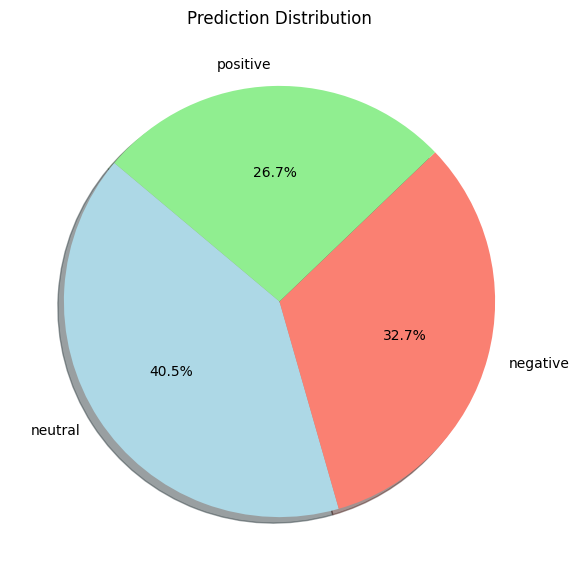

In [48]:
print(df_combined["prediction"].value_counts())
counts = df_combined["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming df_combined has columns: 'date', 'nvda_enhanced_logit', 'sentence', etc.
# First make sure your date column is in datetime format
df_combined['date'] = pd.to_datetime(df_combined['date'])

# Extract just the date portion (without time) if needed
df_combined['market_day'] = df_combined['date'].dt.date

# Function to aggregate logits (stored as lists)
def aggregate_logits(logit_series):
    # Convert each logit list to numpy array for easier manipulation
    logit_arrays = [np.array(logit) for logit in logit_series if isinstance(logit, list)]

    # Check if we have valid logits to aggregate
    if not logit_arrays:
        return [0.33, 0.33, 0.34]  # Default neutral logit if no valid data

    # Calculate the mean of all logits for each position
    avg_logit = np.mean(logit_arrays, axis=0)

    # Return as a list
    return avg_logit.tolist()

# Function to calculate sentiment score from logits
def calculate_sentiment_score(logit):
    # Assuming logit format: [positive, negative, neutral]
    if not isinstance(logit, list) or len(logit) < 3:
        return 0  # Return neutral if invalid logit

    # Calculate sentiment score: positive weight - negative weight
    # This gives a value between -1 and 1
    return logit[0] - logit[1]

# Function to determine prediction from logits
def determine_prediction(logit):
    # Assuming logit format: [positive, negative, neutral]
    if not isinstance(logit, list) or len(logit) < 3:
        return 'neutral'  # Return neutral if invalid logit

    # Find the index of the maximum value
    max_index = np.argmax(logit)

    if max_index == 0:
        return 'positive'
    elif max_index == 1:
        return 'negative'
    else:
        return 'neutral'

# Group by market day and aggregate
market_day_data = []

for day, group in df_combined.groupby('market_day'):
    # Calculate average enhanced logits for the day
    avg_enhanced_logit = aggregate_logits(group['nvda_enhanced_logit'])

    # Calculate original average logits if available
    avg_original_logit = aggregate_logits(group['logit']) if 'logit' in group.columns else [0.33, 0.33, 0.34]

    # Count records and mentions
    record_count = len(group)
    nvidia_direct_mentions = group['has_direct_nvidia'].sum() if 'has_direct_nvidia' in group.columns else 0
    ai_mentions = group['has_ai'].sum() if 'has_ai' in group.columns else 0

    # Calculate sentiment scores
    enhanced_sentiment_score = calculate_sentiment_score(avg_enhanced_logit)
    original_sentiment_score = calculate_sentiment_score(avg_original_logit)

    # Determine predictions
    enhanced_prediction = determine_prediction(avg_enhanced_logit)
    original_prediction = determine_prediction(avg_original_logit)

    # Sample of sentences from the day (optional)
    sample_sentences = group['sentence'].sample(min(3, len(group))).tolist() if 'sentence' in group.columns else []

    # Add to results
    market_day_data.append({
        'market_day': day,
        'record_count': record_count,
        'nvidia_direct_mentions': nvidia_direct_mentions,
        'ai_mentions': ai_mentions,
        'avg_original_logit': avg_original_logit,
        'avg_enhanced_logit': avg_enhanced_logit,
        'original_sentiment_score': original_sentiment_score,
        'enhanced_sentiment_score': enhanced_sentiment_score,
        'original_prediction': original_prediction,
        'enhanced_prediction': enhanced_prediction,
        'sentiment_delta': enhanced_sentiment_score - original_sentiment_score,
        'sample_sentences': sample_sentences
    })

# Create a new dataframe with market day information
df_market_days = pd.DataFrame(market_day_data)

# Sort by date
df_market_days = df_market_days.sort_values('market_day')

# Display the result
print(f"Created market day dataframe with {len(df_market_days)} days")
print(df_market_days[['market_day', 'record_count', 'original_prediction',
                     'enhanced_prediction', 'sentiment_delta']].head())

# Calculate overall prediction changes
prediction_changes = (df_market_days['original_prediction'] != df_market_days['enhanced_prediction']).mean()
positive_days_original = (df_market_days['original_prediction'] == 'positive').sum()
positive_days_enhanced = (df_market_days['enhanced_prediction'] == 'positive').sum()
negative_days_original = (df_market_days['original_prediction'] == 'negative').sum()
negative_days_enhanced = (df_market_days['enhanced_prediction'] == 'negative').sum()

print(f"\nDaily prediction summary:")
print(f"Days with changed prediction: {prediction_changes:.2%}")
print(f"Positive days (original): {positive_days_original} ({positive_days_original/len(df_market_days):.2%})")
print(f"Positive days (enhanced): {positive_days_enhanced} ({positive_days_enhanced/len(df_market_days):.2%})")
print(f"Negative days (original): {negative_days_original} ({negative_days_original/len(df_market_days):.2%})")
print(f"Negative days (enhanced): {negative_days_enhanced} ({negative_days_enhanced/len(df_market_days):.2%})")

Created market day dataframe with 550 days
   market_day  record_count original_prediction enhanced_prediction  \
0  2023-07-12            29             neutral            positive   
1  2023-07-13            31            negative            positive   
2  2023-07-14            16            negative            negative   
3  2023-07-15             4             neutral             neutral   
4  2023-07-16            12             neutral             neutral   

   sentiment_delta  
0         0.007230  
1         0.013099  
2        -0.034571  
3         0.250000  
4        -0.022381  

Daily prediction summary:
Days with changed prediction: 23.64%
Positive days (original): 50 (9.09%)
Positive days (enhanced): 109 (19.82%)
Negative days (original): 79 (14.36%)
Negative days (enhanced): 128 (23.27%)


In [50]:
pd.reset_option('display.max_colwidth')

df_market_days.head()

,market_day,record_count,nvidia_direct_mentions,ai_mentions,avg_original_logit,avg_enhanced_logit,original_sentiment_score,enhanced_sentiment_score,original_prediction,enhanced_prediction,sentiment_delta,sample_sentences
0,2023-07-12,29,2,4,"[0.10388673551724138, 0.10262935758620688, 0.2...","[0.3417563931413324, 0.33326892766250726, 0.32...",0.001257,0.008487,neutral,positive,0.007230,"[In other news of note, oil prices continue to..."
1,2023-07-13,31,2,17,"[0.18700373387096772, 0.19754145774193546, 0.1...","[0.34719169484414875, 0.34463069821412134, 0.3...",-0.010538,0.002561,negative,positive,0.013099,[Metalist diversified REIT said on\n Wednesd...
2,2023-07-14,16,0,2,"[0.06881164000000001, 0.11589727375, 0.0652910...","[0.3330200672977216, 0.41467682649902887, 0.25...",-0.047086,-0.081657,negative,negative,-0.034571,[The QR system gives an overall score of zero ...
3,2023-07-15,4,1,3,"[0.047810899999999996, 0.0319686925, 0.4202203...","[0.3811442369842784, 0.11530202809003538, 0.50...",0.015842,0.265842,neutral,neutral,0.250000,"[And AI driven, I think they feel like, okay, ..."
4,2023-07-16,12,2,2,"[0.07010478833333333, 0.051282214166666666, 0....","[0.12004142754621962, 0.12360028683129731, 0.7...",0.018823,-0.003559,neutral,neutral,-0.022381,[I believe in the Fed attempting to walk the P...


In [79]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Get NVIDIA price data
nvda_price = yf.download('NVDA', start='2023-07-12', end='2025-04-20')
nvda_price = nvda_price.reset_index()
nvda_price.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in nvda_price.columns]
nvda_price['market_day'] = pd.to_datetime(nvda_price['Date']).dt.date

# 2. Merge with sentiment data
merged_data = pd.merge(nvda_price, df_market_days, on='market_day', how='left')

# 3. Fill missing sentiment
sentiment_cols = ['enhanced_sentiment_score', 'avg_enhanced_logit', 'sentiment_delta']
merged_data[sentiment_cols] = merged_data[sentiment_cols].ffill()

# 4. Flatten logits safely
merged_data['logit_pos'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0.33)
merged_data['logit_neg'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else 0.33)
merged_data['logit_neu'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[2] if isinstance(x, list) and len(x) > 2 else 0.34)

# 5. Add technical indicators
merged_data['returns'] = merged_data['Close_NVDA'].pct_change()
merged_data['vol_5d'] = merged_data['returns'].rolling(5).std()
merged_data['ma_5d'] = merged_data['Close_NVDA'].rolling(5).mean()
merged_data['ma_20d'] = merged_data['Close_NVDA'].rolling(20).mean()
merged_data['ma_ratio'] = merged_data['ma_5d'] / merged_data['ma_20d']
merged_data['pred_positive'] = (merged_data['enhanced_prediction'] == 'positive').astype(int)
merged_data['pred_negative'] = (merged_data['enhanced_prediction'] == 'negative').astype(int)

# 6. Drop NaNs
merged_data = merged_data.dropna()

# Define helper: LSTM training + evaluation
def train_and_evaluate(X, y_scaled, model_name="model"):
    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        return np.array(X_seq), np.array(y_seq)

    seq_length = 10
    X_seq, y_seq = create_sequences(X, y_scaled, seq_length)

    split_date = pd.to_datetime("2024-10-01").date()
    split_index = merged_data[merged_data['market_day'] > split_date].index.min()
    X_train, X_test = X_seq[:split_index - seq_length], X_seq[split_index - seq_length:]
    y_train, y_test = y_seq[:split_index - seq_length], y_seq[split_index - seq_length:]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_loss', save_best_only=True)

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
              callbacks=[early_stop, checkpoint], verbose=0)

    model.load_weights(f"{model_name}.h5")
    y_pred_scaled = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = y_scaler.inverse_transform(y_test)

    rmse = np.sqrt(np.mean((y_test_actual - y_pred) ** 2))
    return rmse, y_pred, y_test_actual


# Target variable
y = merged_data['Close_NVDA'].shift(-1).values[:-1]

# ---------------------------------------------------------------

# Model 1: Full
feature_cols_1 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'logit_pos', 'logit_neg', 'enhanced_sentiment_score',
                  'pred_positive', 'pred_negative', 'sentiment_delta']

# Model 2: Price + Score + Logits (no prediction labels)
feature_cols_2 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'logit_pos', 'logit_neg', 'enhanced_sentiment_score']

# Model 3: Price + Score Only
feature_cols_3 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'enhanced_sentiment_score']

feature_cols_baseline = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio']


# ------------------ Model 1: Full Feature Set ------------------

X_1 = merged_data[feature_cols_1].values[:-1]
X_scaler_1 = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled_1 = X_scaler_1.fit_transform(X_1)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))\

# ------------------ Model 2: ['enhanced_sentiment_score', 'avg_enhanced_logit'] ------------------

X_2 = merged_data[feature_cols_2].values[:-1]
X_scaler_2 = MinMaxScaler()
X_scaled_2 = X_scaler_2.fit_transform(X_2)

# ------------------ Model 3: ['enhanced_sentiment_score'] only ------------------

X_3 = merged_data[feature_cols_3].values[:-1]
X_scaler_3 = MinMaxScaler()
X_scaled_3 = X_scaler_3.fit_transform(X_3)

# ------------------ Model baseline: price only ------------------

X_baseline = merged_data[feature_cols_baseline].values[:-1]
X_scaler_baseline = MinMaxScaler()
X_scaled_baseline = X_scaler_baseline.fit_transform(X_baseline)

# ------------------ Final Output ------------------

# ------------------ Model 1 ------------------
rmse_1, y_pred_1, y_test_actual = train_and_evaluate(X_scaled_1, y_scaled, "model_full")

# ------------------ Model 2 ------------------
rmse_2, y_pred_2, _ = train_and_evaluate(X_scaled_2, y_scaled, "model_sent_score_logit")

# ------------------ Model 3 ------------------
rmse_3, y_pred_3, _ = train_and_evaluate(X_scaled_3, y_scaled, "model_sent_score_only")

# ------------------ baseline ------------------
rmse_baseline, y_pred_baseline, _ = train_and_evaluate(X_scaled_baseline, y_scaled, "model_baseline")



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


In [80]:
print(f"RMSE - Price + Score + Logit + delta Model : {rmse_1:.2f}")
print(f"RMSE - Price + Score + Logit Model: {rmse_2:.2f}")
print(f"RMSE - Price + Score Model: {rmse_3:.2f}")
print(f"RMSE - Price Only Model: {rmse_baseline:.2f}")

RMSE - Price + Score + Logit + delta Model : 10.87
RMSE - Price + Score + Logit Model: 9.12
RMSE - Price + Score Model: 9.49
RMSE - Price Only Model: 9.30


In [82]:
def improved_train_and_evaluate(X, y_scaled, model_name="model", n_runs=5):
    results = {"rmse": [], "predictions": []}
    seq_length = 10

    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X, y_scaled, seq_length)

    split_date = pd.to_datetime("2024-10-01").date()
    split_index = merged_data[merged_data['market_day'] > split_date].index.min()
    X_train, X_test = X_seq[:split_index - seq_length], X_seq[split_index - seq_length:]
    y_train, y_test = y_seq[:split_index - seq_length], y_seq[split_index - seq_length:]

    for run in range(n_runs):
        # Set seed for this run
        tf.random.set_seed(42 + run)

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint = ModelCheckpoint(f"{model_name}_run{run}.h5", monitor='val_loss', save_best_only=True)

        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                  callbacks=[early_stop, checkpoint], verbose=0)

        model.load_weights(f"{model_name}_run{run}.h5")
        y_pred_scaled = model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        y_test_actual = y_scaler.inverse_transform(y_test)

        rmse = np.sqrt(np.mean((y_test_actual - y_pred) ** 2))
        results["rmse"].append(rmse)
        results["predictions"].append(y_pred)

    mean_rmse = np.mean(results["rmse"])
    std_rmse = np.std(results["rmse"])
    ensemble_pred = np.mean(np.array(results["predictions"]), axis=0)
    ensemble_rmse = np.sqrt(np.mean((y_test_actual - ensemble_pred) ** 2))

    return {
        "individual_rmse": results["rmse"],
        "mean_rmse": mean_rmse,
        "std_rmse": std_rmse,
        "ensemble_rmse": ensemble_rmse,
        "ensemble_pred": ensemble_pred,
        "y_test_actual": y_test_actual
    }

In [85]:
# Run multiple trials for each model
model_results = {}

# Model 1: Full Feature Set
model_results["full"] = improved_train_and_evaluate(X_scaled_1, y_scaled, "model_full")

# Model 2: Price + Score + Logits
model_results["score_logit"] = improved_train_and_evaluate(X_scaled_2, y_scaled, "model_score_logit")

# Model 3: Price + Score Only
model_results["score_only"] = improved_train_and_evaluate(X_scaled_3, y_scaled, "model_score_only")

# Baseline: Price only
model_results["baseline"] = improved_train_and_evaluate(X_scaled_baseline, y_scaled, "model_baseline")

# Print results
for name, results in model_results.items():
    print(f"\nModel: {name}")
    print(f"Mean RMSE: {results['mean_rmse']:.4f} ± {results['std_rmse']:.4f}")
    print(f"Ensemble RMSE: {results['ensemble_rmse']:.4f}")

# Statistical comparison
from scipy import stats
models = list(model_results.keys())
print("\nStatistical Comparison (p-values):")
for i in range(len(models)):
    for j in range(i+1, len(models)):
        t_stat, p_value = stats.ttest_ind(
            model_results[models[i]]["individual_rmse"],
            model_results[models[j]]["individual_rmse"]
        )
        print(f"{models[i]} vs {models[j]}: p-value = {p_value:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step

Model: full
Mean RMSE: 9.9329 ± 1.0229
Ensemble RMSE: 9.3227

Model: score_logit
Mean RMSE: 10.0128 ± 0.7483
Ensemble RMSE: 9.5127

Model: score_only
Mean RMSE: 9.4635 ± 0.4134
Ensemble RMSE: 9.1923

Model: baseline
Mean RMSE: 10.2127 ± 1.4678
Ensemble RMSE: 9.0608

Statistical Comparison (p-values):
full vs score_logit: p-value = 0.9028
full vs score_only: p-value = 0.4195
full vs baseline: p-value = 0.7625
score_logit vs score_only: p-value = 0.2348
score_logit vs baseline: p-value = 0.8144
score_only vs baseline: p-value = 0.3546


baseline model

In [67]:
#Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)
# Create a second model with only price data (no sentiment)
price_only_cols = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio']

X_price = merged_data[price_only_cols].values[:-1]
X_price_scaler = MinMaxScaler()
X_price_scaled = X_price_scaler.fit_transform(X_price)

seq_length = 10
X_seq, y_seq = create_sequences(X_price_scaled, y_scaled, seq_length)

# 11. Chronological train-test split
split_date = pd.to_datetime("2024-10-01")
split_index = merged_data[merged_data['market_day'] > split_date.date()].index.min()
X_train, X_test = X_seq[:split_index - seq_length], X_seq[split_index - seq_length:]
y_train, y_test = y_seq[:split_index - seq_length], y_seq[split_index - seq_length:]

X_price_seq, _ = create_sequences(X_price_scaled, y_scaled, seq_length)

# Use the same train-test split as the original model
X_price_train, X_price_test = X_price_seq[:split_index - seq_length], X_price_seq[split_index - seq_length:]

# Build baseline model
baseline_model = Sequential()
baseline_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_price_train.shape[1], X_price_train.shape[2])))
baseline_model.add(Dropout(0.2))
baseline_model.add(LSTM(units=50))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(units=1))

baseline_model.compile(optimizer='adam', loss='mean_squared_error')

# Use the same callbacks for consistency
early_stop_baseline = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_baseline = ModelCheckpoint("best_nvda_baseline_model.h5", monitor='val_loss', save_best_only=True)

baseline_model.fit(
    X_price_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_baseline, checkpoint_baseline],
    verbose=1
)

# Load best weights and predict
baseline_model.load_weights("best_nvda_baseline_model.h5")
baseline_pred_scaled = baseline_model.predict(X_price_test)
baseline_pred = y_scaler.inverse_transform(baseline_pred_scaled)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1265

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1060 - val_loss: 0.0123
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0344 - val_loss: 0.0290
Epoch 3/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0132 - val_loss: 0.0069
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0070 - val_loss: 0.0146
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0053 - val_loss: 0.0110
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0044 - val_loss: 0.0138
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0045 - val_loss: 0.0102
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0043 - val_loss: 0.0148
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0043 - val_loss: 0.0113
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 0.0127
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


Final shapes:
y_test_actual: (101, 1)
y_pred_best:   (101, 1)
baseline_pred: (101, 1)
test_dates:    (101,)
RMSE with Sentiment: 9.32
RMSE without Sentiment (Baseline): 9.78
Improvement from Sentiment: 4.62%


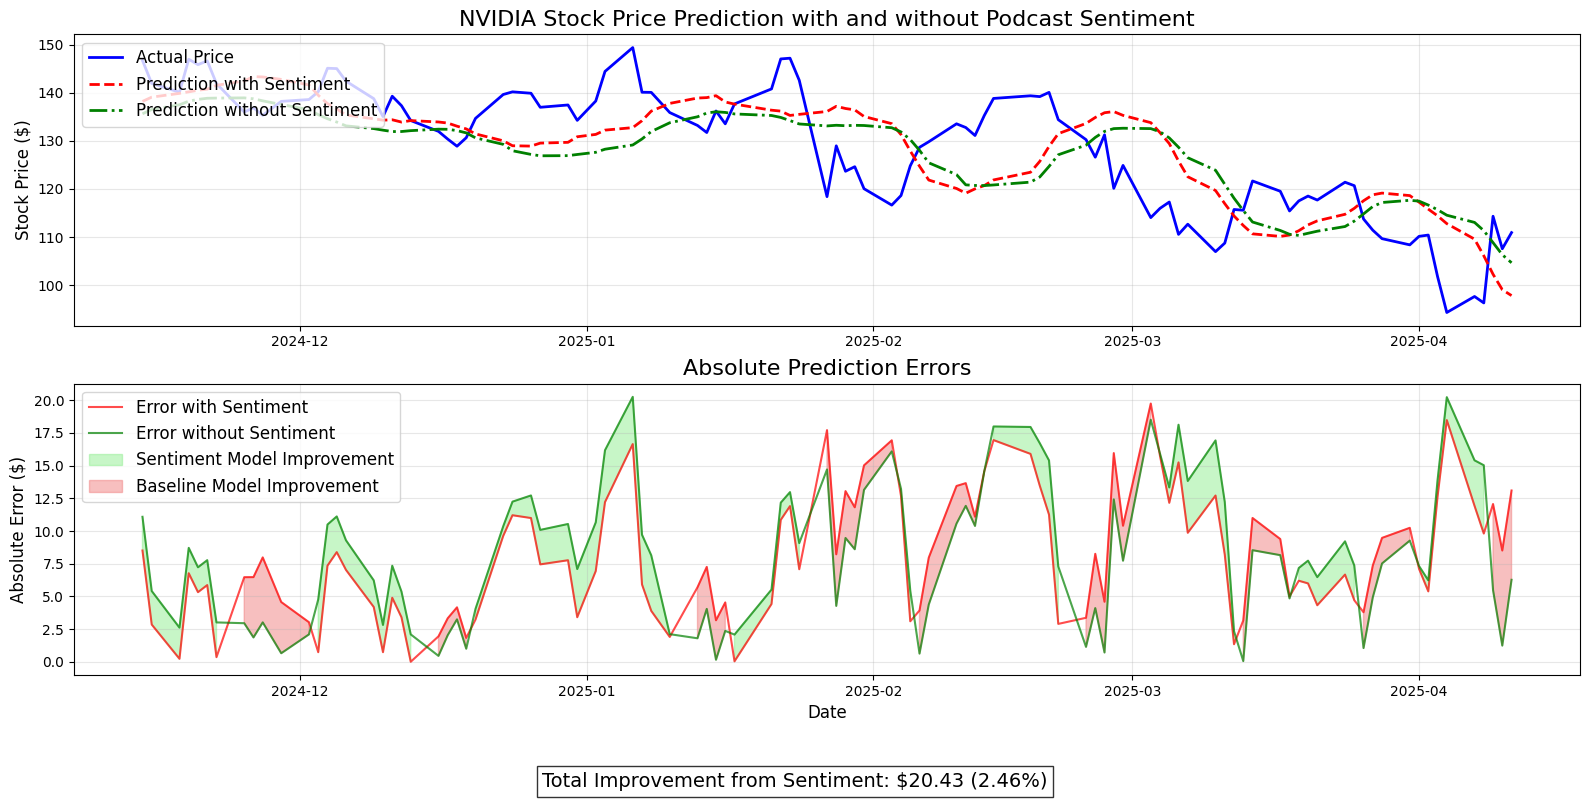

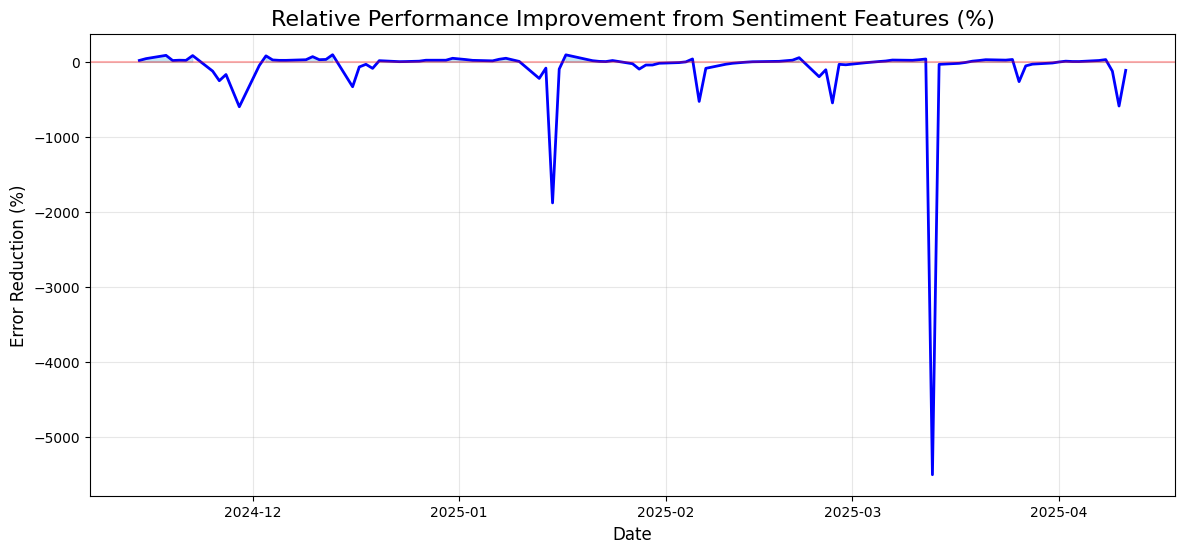

In [59]:
# Align everything to the test sequence length
# Actual test labels — slice AFTER sequencing
y_test_actual = y_scaled[split_index + seq_length:]
y_test_actual = y_scaler.inverse_transform(y_test_actual)

# Reshape predictions to be 2D
y_pred_best = y_pred_1
y_pred_best = y_pred_best.reshape(-1, 1)
baseline_pred = baseline_pred.reshape(-1, 1)

# Slice predictions to match y_test_actual length
y_pred_best = y_pred_best[-len(y_test_actual):]
baseline_pred = baseline_pred[-len(y_test_actual):]

# Dates for plotting — same slice
test_dates = merged_data['market_day'].iloc[split_index + seq_length:].values
test_dates = test_dates[-len(y_test_actual):]

# Optional sanity check
print("Final shapes:")
print(f"y_test_actual: {y_test_actual.shape}")
print(f"y_pred_best:   {y_pred_best.shape}")
print(f"baseline_pred: {baseline_pred.shape}")
print(f"test_dates:    {test_dates.shape}")

# Metrics
sentiment_rmse = np.sqrt(np.mean((y_test_actual - y_pred_best) ** 2))
baseline_rmse = np.sqrt(np.mean((y_test_actual - baseline_pred) ** 2))
improvement = (baseline_rmse - sentiment_rmse) / baseline_rmse

print(f"RMSE with Sentiment: {sentiment_rmse:.2f}")
print(f"RMSE without Sentiment (Baseline): {baseline_rmse:.2f}")
print(f"Improvement from Sentiment: {improvement:.2%}")

# Visualization
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)

plt.plot(test_dates, y_test_actual, 'b-', label='Actual Price', linewidth=2)
plt.plot(test_dates, y_pred_best, 'r--', label='Prediction with Sentiment', linewidth=2)
plt.plot(test_dates, baseline_pred, 'g-.', label='Prediction without Sentiment', linewidth=2)
plt.title('NVIDIA Stock Price Prediction with and without Podcast Sentiment', fontsize=16)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12)

# Error plots
plt.subplot(2, 1, 2)
sentiment_errors = np.abs(y_test_actual - y_pred_best).flatten()
baseline_errors = np.abs(y_test_actual - baseline_pred).flatten()

plt.plot(test_dates, sentiment_errors, 'r-', label='Error with Sentiment', alpha=0.7)
plt.plot(test_dates, baseline_errors, 'g-', label='Error without Sentiment', alpha=0.7)
plt.fill_between(test_dates, sentiment_errors, baseline_errors,
                 where=(baseline_errors > sentiment_errors),
                 color='lightgreen', alpha=0.5,
                 label='Sentiment Model Improvement')
plt.fill_between(test_dates, sentiment_errors, baseline_errors,
                 where=(baseline_errors <= sentiment_errors),
                 color='lightcoral', alpha=0.5,
                 label='Baseline Model Improvement')
plt.title('Absolute Prediction Errors', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Absolute Error ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12)

# Cumulative improvement
cum_sentiment_error = np.cumsum(sentiment_errors)
cum_baseline_error = np.cumsum(baseline_errors)
cum_improvement = cum_baseline_error[-1] - cum_sentiment_error[-1]
cum_improvement_pct = (cum_improvement) / cum_baseline_error[-1]

plt.figtext(0.5, 0.01,
           f"Total Improvement from Sentiment: ${cum_improvement:.2f} ({cum_improvement_pct:.2%})",
           ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('nvidia_sentiment_prediction_comparison.png', dpi=300)
plt.show()

# Relative error improvement chart
plt.figure(figsize=(14, 6))
relative_improvement = (baseline_errors - sentiment_errors) / baseline_errors * 100
plt.plot(test_dates, relative_improvement, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.fill_between(test_dates, relative_improvement, 0,
                 where=(relative_improvement > 0),
                 color='skyblue', alpha=0.5)
plt.title('Relative Performance Improvement from Sentiment Features (%)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Error Reduction (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('nvidia_sentiment_improvement_percentage.png', dpi=300)
plt.show()


In [60]:
def train_and_evaluate(X, y_scaled, model_name="model", return_model=False):
    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        return np.array(X_seq), np.array(y_seq)

    seq_length = 10
    X_seq, y_seq = create_sequences(X, y_scaled, seq_length)

    split_date = pd.to_datetime("2024-10-01").date()
    split_index = merged_data[merged_data['market_day'] > split_date].index.min()
    X_train, X_test = X_seq[:split_index - seq_length], X_seq[split_index - seq_length:]
    y_train, y_test = y_seq[:split_index - seq_length], y_seq[split_index - seq_length:]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_loss', save_best_only=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, checkpoint],
        verbose=0
    )

    model.load_weights(f"{model_name}.h5")
    y_pred_scaled = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = y_scaler.inverse_transform(y_test)

    rmse = np.sqrt(np.mean((y_test_actual - y_pred) ** 2))

    if return_model:
        return rmse, y_pred, y_test_actual, history, model
    else:
        return rmse, y_pred, y_test_actual, history


In [61]:

# Target variable
y = merged_data['Close_NVDA'].shift(-1).values[:-1]

# ---------------------------------------------------------------

# Model 1: Full
feature_cols_1 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'logit_pos', 'logit_neg', 'enhanced_sentiment_score',
                  'pred_positive', 'pred_negative', 'sentiment_delta']

# Model 2: Price + Score + Logits (no prediction labels)
feature_cols_2 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'logit_pos', 'logit_neg', 'enhanced_sentiment_score']

# Model 3: Price + Score Only
feature_cols_3 = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
                  'returns', 'vol_5d', 'ma_ratio',
                  'enhanced_sentiment_score']


# ------------------ Model 1: Full Feature Set ------------------

X_1 = merged_data[feature_cols_1].values[:-1]
X_scaler_1 = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled_1 = X_scaler_1.fit_transform(X_1)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))\

# ------------------ Model 2: ['enhanced_sentiment_score', 'avg_enhanced_logit'] ------------------

X_2 = merged_data[feature_cols_2].values[:-1]
X_scaler_2 = MinMaxScaler()
X_scaled_2 = X_scaler_2.fit_transform(X_2)

# ------------------ Model 3: ['enhanced_sentiment_score'] only ------------------

X_3 = merged_data[feature_cols_3].values[:-1]
X_scaler_3 = MinMaxScaler()
X_scaled_3 = X_scaler_3.fit_transform(X_3)

# ------------------ Final Output ------------------

# ------------------ Model 1: Price + Score + Logit + Delta ------------------
rmse_1, y_pred_1, y_test_actual, history_1, model_1 = train_and_evaluate(
    X_scaled_1, y_scaled, "model_full", return_model=True)

# ------------------ Model 2: Price + Score + Logit ------------------
rmse_2, y_pred_2, _, history_2, model_2 = train_and_evaluate(
    X_scaled_2, y_scaled, "model_sent_score_logit", return_model=True)

# ------------------ Model 3: Price + Score ------------------
rmse_3, y_pred_3, _, history_3, model_3 = train_and_evaluate(
    X_scaled_3, y_scaled, "model_sent_score_only", return_model=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


In [66]:
print(f"RMSE - Price + Score + Logit + delta Model : {rmse_1:.2f}")
print(f"RMSE - Price + Score + Logit Model: {rmse_2:.2f}")
print(f"RMSE - Price + Score Model: {rmse_3:.2f}")

RMSE - Price + Score + Logit + delta Model : 9.67
RMSE - Price + Score + Logit Model: 10.06
RMSE - Price + Score Model: 9.25


In [ ]:
def plot_multi_loss(histories, labels):
    plt.figure(figsize=(10, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} (val)', linestyle='--')
        plt.plot(history.history['loss'], label=f'{label} (train)', linestyle='-')
    plt.title("Training vs Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_multi_loss(
    histories=[history_1, history_2, history_3],
    labels=["Full Model", "Score + Logits", "Score Only"]
)


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(actual_direction[:30], label='Actual Direction')
plt.plot(pred_direction[:30], label='Sentiment Model Direction')
plt.title("First 30 Days - Price Movement Direction")
plt.legend()
plt.grid(True)
plt.show()


The chart displays the price movement direction over the first 30 days, comparing the "Actual Direction" with the "Sentiment Model Direction".

Looking at the two lines, it appears that the Sentiment Model Direction is largely inverted relative to the Actual Direction. When the blue line (Actual Direction) goes up, the orange line (Sentiment Model Direction) tends to go down, and vice versa.

There also seems to be a slight lag in the Sentiment Model's movements compared to the Actual Direction. The peaks and troughs of the orange line appear to occur a little after the peaks and troughs of the blue line.

It doesn't appear to be completely random, as there's a clear pattern of opposition between the two lines.

In summary, based on the visual representation:

The Sentiment Model Direction is significantly inverted compared to the Actual Direction.
There is a suggestion of a lag in the Sentiment Model's predictions.

In [ ]:
# Ensure same length before shifting
y_pred_trimmed = y_pred.flatten()[-len(y_test_actual):]

# Now apply shift + flip
shifted_flipped = -np.roll(y_pred_trimmed, -1)

# Remove last element after shift (it's now garbage)
shifted_flipped = shifted_flipped[:-1]
actual_direction = np.sign(np.diff(y_test_actual.flatten()))

# Get predicted direction
shifted_flipped_dir = np.sign(np.diff(shifted_flipped))

# Ensure shape match
actual_direction = actual_direction[:len(shifted_flipped_dir)]

# Accuracy
combo_accuracy = np.mean(actual_direction == shifted_flipped_dir)
print(f"Shifted + Flipped direction accuracy: {combo_accuracy:.2%}")



In [ ]:
print(merged_data[features].dtypes)


In [ ]:

from sklearn.preprocessing import MinMaxScaler

# ---- Preprocessing ----

# Select sentiment + price features
features = ['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA',
            'returns', 'vol_5d', 'ma_ratio', 'enhanced_sentiment_score', 'avg_enhanced_logit']
target_price = merged_data['Close_NVDA'].values
target_direction = (merged_data['returns'].shift(-1) > 0).astype(int).values  # 1 = up, 0 = down

# Scale features
X_raw = merged_data[features].values[:-1]
y_price = target_price[1:]  # shift 1 day ahead for price prediction
y_direction = target_direction[1:]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Create sequences
def create_dual_sequences(X, y_price, y_dir, seq_len):
    X_seq, y_price_seq, y_dir_seq = [], [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_price_seq.append(y_price[i])
        y_dir_seq.append(y_dir[i])
    return np.array(X_seq), np.array(y_price_seq), np.array(y_dir_seq)

seq_len = 20
X_seq, y_price_seq, y_dir_seq = create_dual_sequences(X_scaled, y_price, y_direction, seq_len)

# Train-test split
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_price_train, y_price_test = y_price_seq[:split_index], y_price_seq[split_index:]
y_dir_train, y_dir_test = y_dir_seq[:split_index], y_dir_seq[split_index:]

# Convert direction labels to categorical
y_dir_train_cat = to_categorical(y_dir_train, num_classes=2)
y_dir_test_cat = to_categorical(y_dir_test, num_classes=2)

# ---- Dual-Head Model ----

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=False)(input_layer)
x = Dropout(0.3)(x)

# Price regression head
price_output = Dense(1, name='price_output')(x)

# Direction classification head
direction_output = Dense(2, activation='softmax', name='direction_output')(x)

# Full model
model = Model(inputs=input_layer, outputs=[price_output, direction_output])
model.compile(optimizer='adam',
              loss={'price_output': 'mse', 'direction_output': 'categorical_crossentropy'},
              metrics={'price_output': 'mse', 'direction_output': 'accuracy'})

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ---- Training ----

history = model.fit(X_train, {'price_output': y_price_train, 'direction_output': y_dir_train_cat},
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# ---- Evaluation ----

# Predict
price_pred = model.predict(X_test)[0]
direction_pred_prob = model.predict(X_test)[1]
direction_pred_class = np.argmax(direction_pred_prob, axis=1)

# Metrics
from sklearn.metrics import mean_squared_error, accuracy_score

rmse = np.sqrt(mean_squared_error(y_price_test, price_pred))
accuracy = accuracy_score(y_dir_test, direction_pred_class)

print(f"\n📈 Regression RMSE (Price Head): {rmse:.2f}")
print(f"🔁 Classification Accuracy (Direction Head): {accuracy:.2%}")

# Optional: direction accuracy from regression output (sign)
regression_direction = np.sign(np.diff(price_pred.flatten()))
true_direction = np.sign(np.diff(y_price_test.flatten()))
direction_from_price_head = np.mean(regression_direction == true_direction[:len(regression_direction)])
print(f"🧪 Direction Accuracy from Price Predictions (sign-based): {direction_from_price_head:.2%}")


Feature importance

In [ ]:
# Try a simpler model to analyze feature importance
from sklearn.ensemble import RandomForestRegressor

# Flatten sequences for RandomForest
X_flat = X_scaled[seq_length:]
y_flat = y_scaled.reshape(-1)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_flat, y_flat)

# Get feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance:")
print(importance)

direction accuracy

In [ ]:
# Calculate direction accuracy
actual_direction = np.sign(np.diff(y_test_actual.flatten()))
pred_direction = np.sign(np.diff(y_pred.flatten()))
direction_accuracy = np.mean(actual_direction == pred_direction)
print(f"Direction prediction accuracy: {direction_accuracy:.2%}")

In [ ]:
baseline_direction = np.sign(np.diff(baseline_pred.flatten()))
baseline_accuracy = np.mean(actual_direction == baseline_direction)
print(f"Baseline direction accuracy: {baseline_accuracy:.2%}")


In [ ]:
import re

neg_keywords = [
    "china", "sanctions", "competition", "amd", "intel",
    "downgrade", "shortage", "tariff", "bearish", "headwinds"
]

core_keywords = [
    "nvidia", "cuda", "gpu", "chip", "semiconductor", "semiconductors",
    "ai", "generative", "llm", "inference", "nasdaq", "fomc", "tech",
    "chipmaker", "buyback", "bullish", "hyperscaler",
    "azure", "amazon", "aws", "open ai", "dell", "tsmc"
]

# Regex-safe
neg_pattern = r"\b(" + "|".join(re.escape(k) for k in neg_keywords) + r")\b"
core_pattern = r"\b(" + "|".join(re.escape(k) for k in core_keywords) + r")\b"


In [ ]:
# Negative keywords (potentially negative for NVIDIA)
neg_keywords = [
    # Geopolitical/Regulatory
    "china restrictions", "export controls", "sanctions", "tariff", "trade war", "regulatory scrutiny",
    "antitrust", "chip ban", "export limitation", "license requirement",

    # Competition
    "amd gain", "intel advance", "apple silicon", "competitor launch", "market share loss",
    "qualcomm ai", "google tpu", "amazon inferentia", "microsoft azure chip", "tesla dojo",

    # Business Challenges
    "gpu shortage", "supply constraint", "margin pressure", "price cut", "downgrade",
    "missed forecast", "demand slowdown", "inventory glut", "crypto decline", "mining crash",

    # Market Sentiment
    "bearish", "overvalued", "bubble", "sell rating", "price target cut", "headwinds",
    "overbought", "peak growth", "premium valuation", "profit taking"
]

# Positive keywords (potentially positive for NVIDIA)
pos_keywords = [
    # Technology/Product Strength
    "ai demand", "gpu demand", "data center growth", "next-gen", "new launch", "performance lead",
    "blackwell", "hopper", "benchmark win", "technological advantage",

    # Business Success
    "revenue beat", "raised guidance", "market share gain", "price increase", "margin expansion",
    "strong forecast", "analyst upgrade", "raised target", "new partnership", "design win",

    # Competitor Weakness
    "amd delay", "intel struggle", "competitor setback", "market leadership", "widening gap",

    # Market Expansion
    "new vertical", "automotive growth", "cloud adoption", "ai investment", "enterprise expansion",
    "generative ai", "large language model", "training demand", "inference growth", "supercomputing win"
]

# Context-dependent keywords (need additional analysis)
context_keywords = [
    "china", "taiwan", "acquisition", "lawsuit", "patent", "ceo", "restructuring",
    "supply chain", "competition", "regulation", "crypto", "gaming", "data center",
    "intel", "amd", "cloud", "ai", "semiconductor", "chip"
]

In [ ]:
df.head()

In [ ]:
df["has_nvda_keywords"] = df["sentence"].str.contains(core_pattern, case=False, na=False)
df["has_macro_risk"] = df["sentence"].str.contains(neg_pattern, case=False, na=False)

In [ ]:
df_nvda_relevant = df[df["has_macro_risk"] | df["has_nvda_keywords"]].copy()
df_macro_risk = df[df["has_macro_risk"]].copy()
# Show all rows and full column content
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df_macro_risk.head()

In [ ]:
grouped.head(99)

In [ ]:
print(df_filter["prediction"].value_counts())
counts = df_filter["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()

